In [1]:
import numpy as np
import pandas as pd
import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random

In [2]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

def split_data(data, training_split, features):
  split_row = int(data.shape[0]*training_split)
  training_set = data[features].iloc[:split_row].values
  testing_set = data[features].iloc[split_row:].values
  return training_set, testing_set

def get_x_y(dataset, window_size, label_feature, feature_count):
  X, y = [], []
  for i in range(window_size, len(dataset)):
    X.append(dataset[i-window_size:i])
    y.append(dataset[i, label_feature])

  X, y = np.array(X), np.array(y)
  X = np.reshape(X, (X.shape[0], window_size, feature_count))
  return X, y

def MASE(Actual, Predicted):
    n = len(Actual)
    
    # Calculate the mean absolute error of the naive forecast
    naive_errors = [abs(Actual[i] - Actual[i-1]) for i in range(1, n)]
    naive_mae = np.mean(naive_errors)
    
    # Calculate the MASE
    mase_values = [abs(Actual[i] - Predicted[i]) / naive_mae for i in range(n)]
    
    return np.mean(mase_values)

def build_model(window_size, feature_count, lstm_units, d, dense_units):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(window_size, feature_count), return_sequences=True))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(LSTM(lstm_units))
    model.add(Dropout(d))
    model.add(Dense(dense_units, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['mae'])
    return model

symbol = "AAPL"
company_df = pd.read_csv(f'../data/{symbol}/{symbol}_2024-06-24.csv')

market_df = pd.read_csv(f'../data/market_data/market_data_2024-06-24.csv')
market_df['Date'] = pd.to_datetime(market_df['Date'])
company_df['timestamp'] = pd.to_datetime(company_df['timestamp'])
df = pd.merge(market_df, company_df, left_on='Date', right_on='timestamp', how='inner')

# training_set, testing_set = split_data(df, 0.8, [
#     'Value_interest', 'Value_inflation', 'Value_gdp',
#     'Value_unemployment', 'Value_cci', 'Open_sp500', 'High_sp500',
#     'Low_sp500', 'Close_sp500', 'Volume_sp500', 'Open_nasdaq',
#     'High_nasdaq', 'Low_nasdaq', 'Close_nasdaq', 'Volume_nasdaq',
#     'Open_dow_jones', 'High_dow_jones', 'Low_dow_jones', 'Close_dow_jones',
#     'Volume_dow_jones', 'Open_tech_sector', 'High_tech_sector',
#     'Low_tech_sector', 'Close_tech_sector', 'Volume_tech_sector',
#     'open', 'high', 'low', 'close', 'volume'
#     ])

training_set, testing_set = split_data(df, 0.8, [
    'Close_sp500', 'Close_nasdaq', 
    'Close_dow_jones','Close_tech_sector',
    'open', 'high', 'low', 
    'close', 'volume'])

print("training_set: ", training_set.shape)
print("testing_set: ", testing_set.shape)

window_size = 60
feature_count = 9
label_index = 7

scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
testing_set = scaler.fit_transform(testing_set)


X_train, y_train = get_x_y(training_set, window_size, label_index, feature_count)      # Change this line if you added more features
val_split_row = int(X_train.shape[0]*0.8)               # 20% will be used for validation
X_train, X_val = X_train[:val_split_row], X_train[val_split_row:]
y_train, y_val = y_train[:val_split_row], y_train[val_split_row:]
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print(training_set)
print(y_train)

training_set:  (4924, 9)
testing_set:  (1231, 9)
X_train:  (3891, 60, 9)
y_train:  (3891,)
X_val:  (973, 60, 9)
y_val:  (973,)
[[0.28984458 0.25945115 0.19707083 ... 0.09412535 0.09361665 0.00945048]
 [0.28711548 0.26140802 0.19386742 ... 0.094038   0.09743389 0.01515476]
 [0.29019109 0.26797011 0.19517529 ... 0.09941035 0.09924816 0.01180887]
 ...
 [0.98721853 0.98978448 0.99330627 ... 0.27742593 0.27610381 0.07097895]
 [0.99179135 0.99286819 0.99345624 ... 0.27805198 0.27945659 0.09467246]
 [0.98387782 0.98436465 0.99015184 ... 0.27610104 0.27500073 0.10710055]]
[0.12845075 0.13154228 0.12646231 ... 0.13062788 0.13152777 0.14016372]


In [3]:
model = build_model(window_size, feature_count, 64, 0.2, 16)
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=200, batch_size=16, callbacks=[early_stopping, reduce_lr])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            18944     
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 86,049
Trainable params: 86,049
Non-traina

In [4]:
# Get X and y from testing set
X_test, y_test = get_x_y(testing_set, window_size, label_index, feature_count)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)
print(y_test)

loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

y_pred = model.predict(X_test)

full_test_set = np.zeros((len(y_test), feature_count))
full_test_set[:, label_index] = y_test
y_test_inverse = scaler.inverse_transform(full_test_set)[:, label_index]

full_pred_set = np.zeros((len(y_pred), feature_count))
full_pred_set[:, label_index] = y_pred[:, 0]  # Ensure y_pred is 2D
y_pred_inverse = scaler.inverse_transform(full_pred_set)[:, label_index]

print("Inverted (using stock prices)")
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

print("Using MinMaxScaler")
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

# model.save_weights(f'weights/{symbol}_model2.weights.h5')

X_test:  (1171, 60, 9)
y_test:  (1171,)
[0.31942392 0.32170319 0.3245335  ... 0.25758297 0.25209768 0.25372574]
37/37 [==============================] - 0s 9ms/step - loss: 9.5305e-04 - mae: 0.0118
Test Loss: [0.0009530492825433612, 0.011770181357860565]
37/37 [==============================] - 1s 10ms/step
Inverted (using stock prices)
Mean Absolute Error (MAE): 4.699245754854739
Mean Squared Error (MSE): 151.91658709514329
Root Mean Squared Error (RMSE): 12.325444701719418
Using MinMaxScaler
Mean Absolute Error (MAE): 0.011770183481164032
Mean Squared Error (MSE): 0.0009530492534814189
Root Mean Squared Error (RMSE): 0.030871495808940306
Evaluate on test data
37/37 [==============================] - 0s 9ms/step - loss: 9.5305e-04 - mae: 0.0118
test loss, test acc: [0.0009530492825433612, 0.011770181357860565]


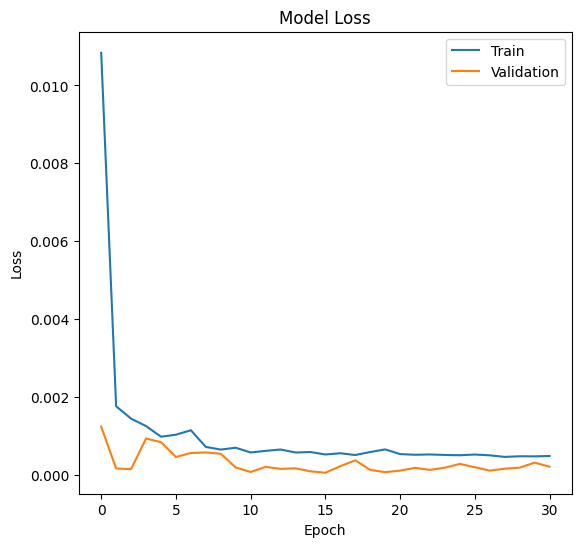

In [5]:
# Plot training & validation loss values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

In [6]:
# Predict X_train and X_val
p_train = model.predict(X_train)
print(p_train.shape)
p_train

122/122 [==============================] - 1s 9ms/step
(3891, 1)


array([[0.1466807 ],
       [0.1447885 ],
       [0.14140949],
       ...,
       [0.14981551],
       [0.14212221],
       [0.14107168]], dtype=float32)

In [7]:
# # Predict X_train and X_val
# p_train = model.predict(X_train)
# p_train = scaler.inverse_transform(p_train)
# p_val = model.predict(X_val)
# p_val = scaler.inverse_transform(p_val)

# # Compare p_train and y_train
# plt.plot(p_train, color='red', label='prediction on training samples')
# plt.plot(scaler.inverse_transform(y_train.reshape((-1, 1))), color='blue', label='y_train')
# plt.xlabel('No. of Trading Days')
# plt.ylabel('Opening Value')
# plt.legend(loc='upper left')
# fig = plt.gcf()
# fig.set_size_inches(30,10)
# plt.show()

37/37 [==============================] - 0s 9ms/step
Inverted (using stock prices)
Mean Absolute Error (MAE): 4.699245754854739
Mean Absolute Scaled Error (MASE): 1.555803894996643
Mean Squared Error (MSE): 151.91658709514329
Root Mean Squared Error (RMSE): 12.325444701719418
Using MinMaxScaler
Mean Absolute Error (MAE): 0.011770183481164032
Mean Squared Error (MSE): 0.0009530492534814189
Root Mean Squared Error (RMSE): 0.030871495808940306


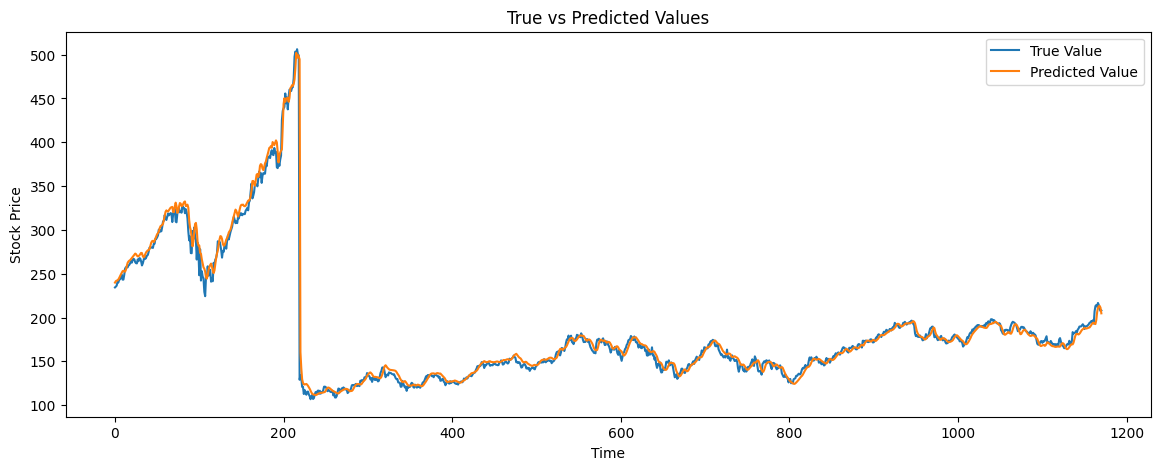

In [8]:
# Generate predictions
y_pred = model.predict(X_test)

full_test_set = np.zeros((len(y_test), feature_count))
full_test_set[:, label_index] = y_test
y_test_inverse = scaler.inverse_transform(full_test_set)[:, label_index]

full_pred_set = np.zeros((len(y_pred), feature_count))
full_pred_set[:, label_index] = y_pred[:, 0]  # Ensure y_pred is 2D
y_pred_inverse = scaler.inverse_transform(full_pred_set)[:, label_index]

print("Inverted (using stock prices)")
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f'Mean Absolute Error (MAE): {mae}')

mase = MASE(y_test, y_pred)
print(f'Mean Absolute Scaled Error (MASE): {mase}')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')


print("Using MinMaxScaler")
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plotting
plt.figure(figsize=(14, 5))
plt.plot(y_test_inverse, label='True Value')
plt.plot(y_pred_inverse, label='Predicted Value')
plt.title('True vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

37/37 [==============================] - 0s 8ms/step


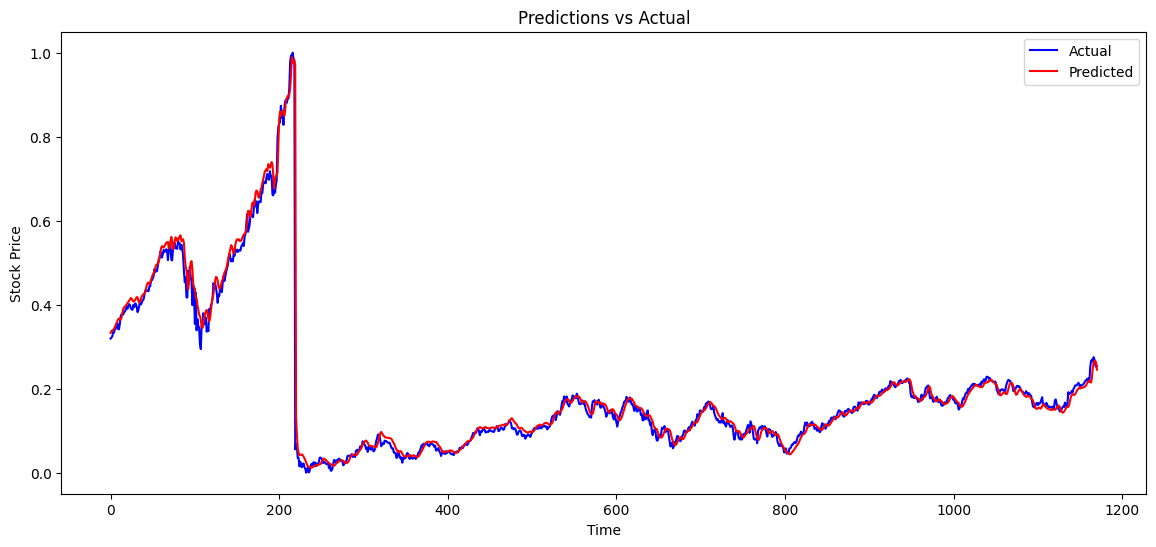

In [9]:
# Generate predictions
y_pred = model.predict(X_test)

# Plot predictions vs actual results
plt.figure(figsize=(14, 6))
plt.plot(y_test, color='blue', label='Actual')
plt.plot(y_pred, color='red', label='Predicted')
plt.title('Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(['Actual', 'Predicted'], loc='upper right')
plt.show()

In [10]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
37/37 [==============================] - 0s 9ms/step - loss: 9.5305e-04 - mae: 0.0118
test loss, test acc: [0.0009530492825433612, 0.011770181357860565]


In [12]:
model.save_weights(f'../weights/{symbol}_best_model.weights.h5')